# Data Exploration

In [1]:
RGR.Raw <- read.csv("C:/Users/jodyn/OneDrive/Github/Trait-Performance-Relationships/data/RGR.csv")
MSH.Raw <- read.csv("C:/Users/jodyn/OneDrive/Github/Trait-Performance-Relationships/data/MSH all data_July2015.csv")

In [2]:
# what do these  data look like?
head(RGR.Raw)

SampleID,BA.0.2006,BA.0.2007,BA.0.2008,BA.0.2009,BA.0.2010,BA.0.2011
J10ACSA19,12.018423,NA,NA,NA,NA,12.437202
J10AMSP12,11.916452,12.604177,13.434528,14.603302,15.698010,16.527046
J10AMSP13,4.978399,5.334679,5.961424,6.940494,8.224628,9.186387
J10FAG15,6.611162,7.442033,8.581504,9.681168,10.510053,11.293637
J10FRA19,10.509488,10.799639,11.158824,11.554593,12.002439,12.548089
J10OSV19,1.857446,2.135612,2.383083,2.551090,2.824035,3.094184


In [3]:
head(MSH.Raw)

Sample.ID,Height.DBH.Ratio,Estem,Etwig,Branching.Distance,Twig.Diameter,Twig.Wood.Density,Stem.Wood.Density,Leaf.Mass.Fraction,Leaf.Area,...,Leaf.Thickness,Leaf.Density,C.N,C.P,N.P,Kl,Kleaf,Biomass1,pcent.max.Bio1,Total.Transmitted.Light
J10ACSA19,120.00000,2807.719,368.4968,16.750000,5.440,0.6568855,0.7900303,0.8552029,43.42781,...,0.0938,0.3864892,25.47644,5.815661,0.2282760,453.3973,0.2043562,0.06979659,0.006456624,2.425
J10AMSP12,98.29268,2012.670,539.4002,8.000000,4.395,0.6276060,0.8900391,1.0007018,13.62967,...,0.1218,0.3794966,18.72918,4.112673,0.2195864,306.8134,0.7228903,0.82903646,0.227458171,3.890
J10AMSP13,160.66667,7055.698,378.0921,11.368421,5.400,0.6641150,0.8772109,0.6397234,18.23260,...,0.1334,0.3663307,21.29783,4.364887,0.2049452,259.7530,0.4825453,0.96175893,0.279222457,4.590
J10FAG15,141.42857,3871.404,722.9500,9.777778,3.725,0.6042533,0.7510540,1.5427180,51.98562,...,0.0854,0.4024881,21.06370,4.721752,0.2241654,349.5795,0.6831540,0.78358389,0.190223535,2.980
J10FRA19,113.94737,3121.343,113.9802,56.000000,8.935,0.5481215,0.7678219,1.1889349,354.28250,...,0.0924,0.4778804,18.15457,3.843781,0.2117253,2310.4256,0.4141856,0.54564968,0.188202909,6.500
J10OSV19,193.33333,4496.479,684.6123,8.285714,3.760,0.5830135,0.7995936,1.5381013,19.58762,...,0.1070,0.3369430,22.02248,5.631711,0.2557255,578.3284,1.6445056,0.27014928,0.180795948,2.820


Okay, those were way more columns than I anticipated. Best to ask R which/how many columns have NAs.

In [4]:
length(names(which(apply(MSH.Raw, 2, anyNA))))

[1] 30

In [5]:
# not sure how many columns there are in the first place. is that alot?
ncol(MSH.Raw)

[1] 70

In [6]:
length(names(which(apply(RGR.Raw, 2, anyNA))))

[1] 6

In [7]:
ncol(RGR.Raw)

[1] 7

So, 30/70 columns in the trait data have NAs. That's ~43%. I may have to do some imputation to fill in those NAs. For the growth rate dataset, 6/7 columns have NAs. That's about 85%. 

There are numerous packages I can use for this step, but a paper I read (Handling missing values: A study of popular imputation packages in R) recommends VIM. The authors argue that VIM seems to have higher accuracy and does better with smaller datasets (n<15000). I can use 1 of four methods in VIM (https://core.ac.uk/download/pdf/156957839.pdf). I will do some reading on which of the four I should use over the weekend.

After doing reading, I will use the robust  EMbased imputation method, which is the only method in the package that does multiple imputations. For this method, we use both the variance and OLS to fill in the missing values. But, here, we are using the observed data to estimate multiple values at a time. These values should reflect the uncertainty around the true value.

I will compare performance between just running the model without the missing cases vs the imputated dataset. If the results converge, I will use the imputated dataset.

In [8]:
library(VIM)
library(FactoMineR)
library(missMDA)
library(naniar)

Warning message:
"package 'VIM' was built under R version 3.6.3"Loading required package: colorspace
Loading required package: grid
VIM is ready to use.

Suggestions and bug-reports can be submitted at: https://github.com/statistikat/VIM/issues

Attaching package: 'VIM'

The following object is masked from 'package:datasets':

    sleep

Warning message:
"package 'FactoMineR' was built under R version 3.6.3"Warning message:
"package 'missMDA' was built under R version 3.6.3"Warning message:
"package 'naniar' was built under R version 3.6.3"

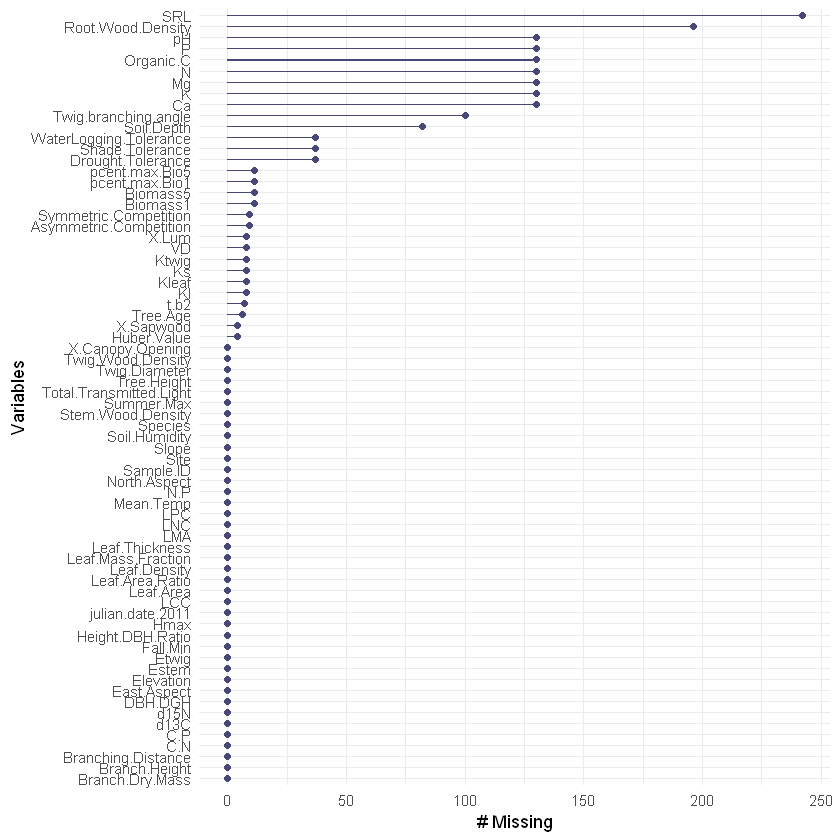

In [9]:
# where are most of the missing data?
gg_miss_var(MSH.Raw)

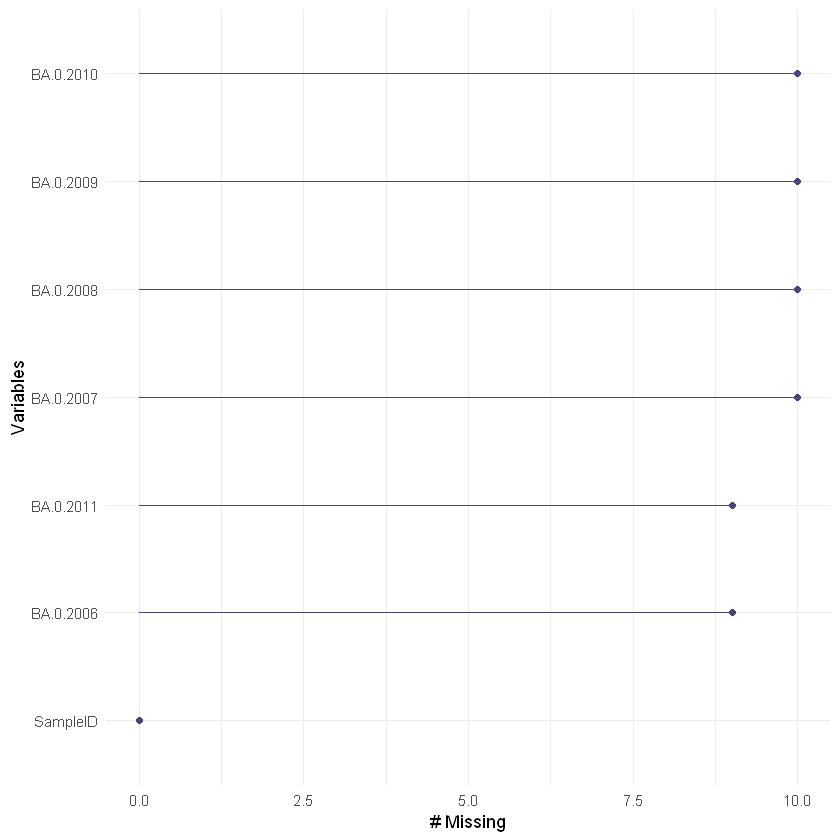

In [13]:
# where are most of the missing data?
gg_miss_var(RGR.Raw)

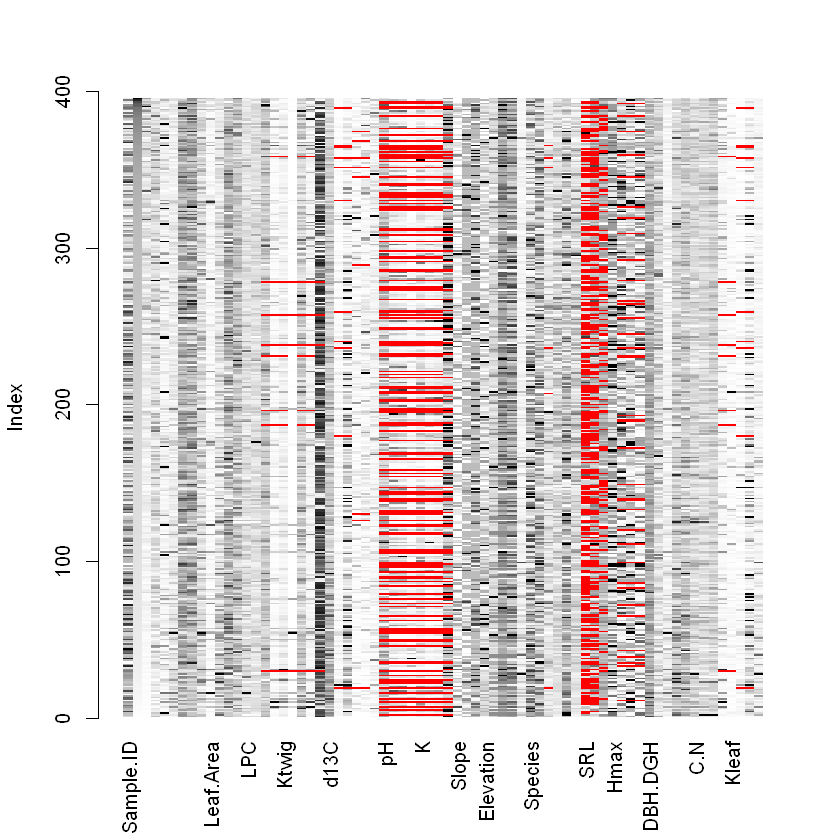

In [12]:
# is there a trend in where data is missing?
matrixplot(MSH.Raw, sortby = 2)

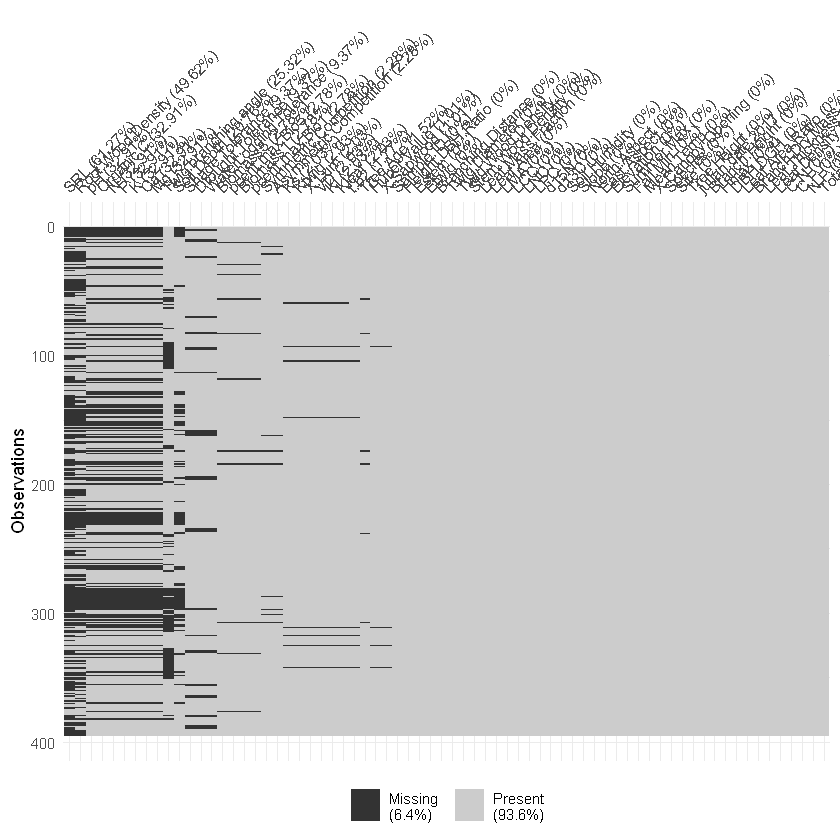

In [16]:
vis_miss(MSH.Raw, sort_miss = TRUE) 

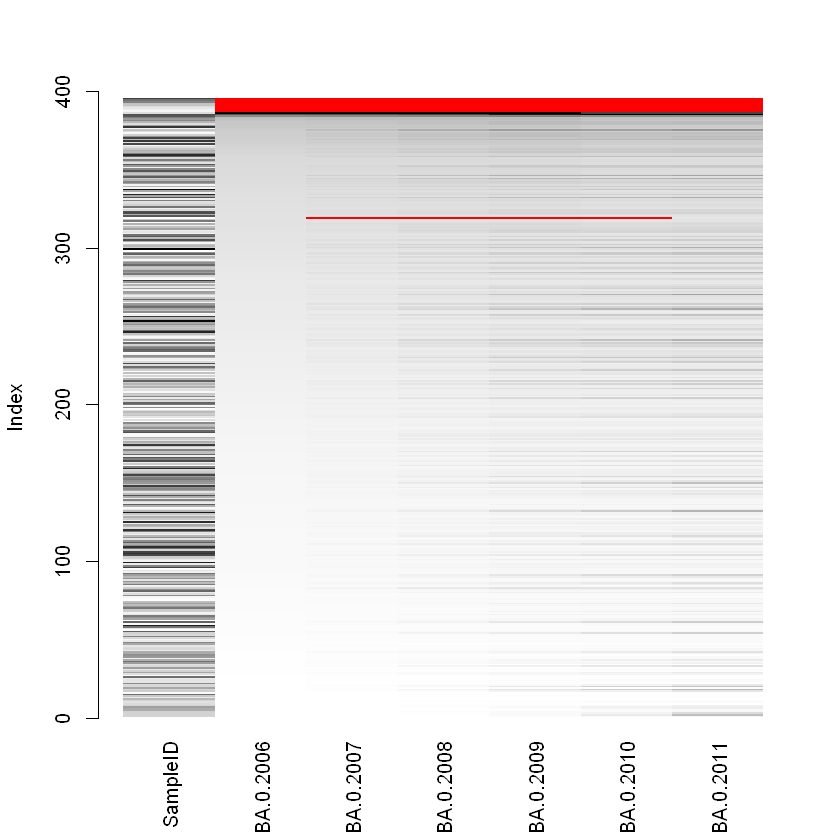

In [14]:
# is there a trend in where data is missing?
matrixplot(RGR.Raw, sortby = 2)

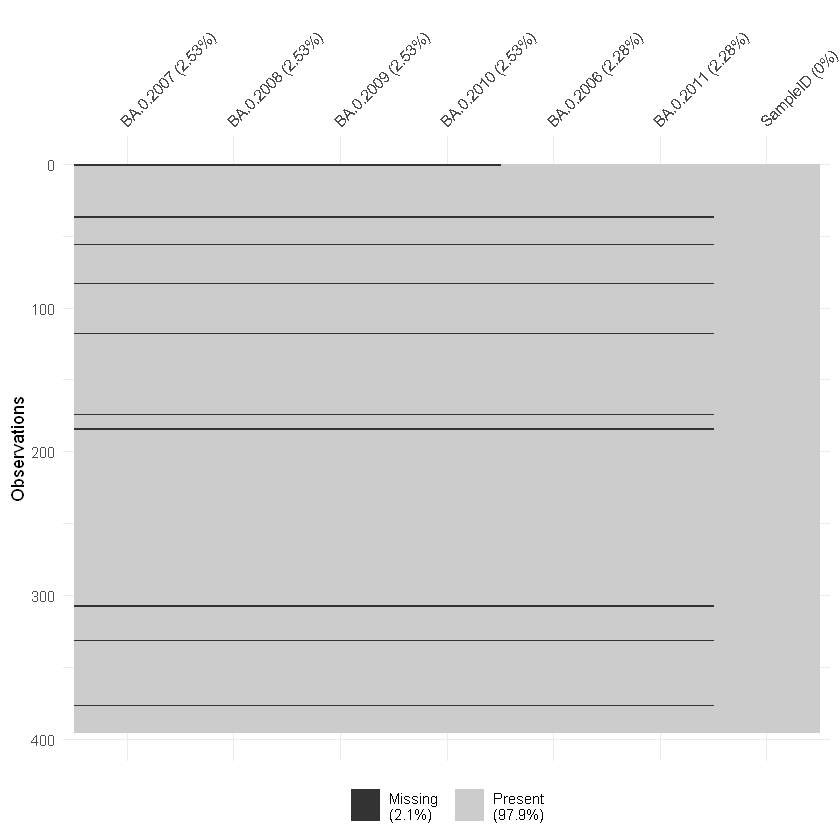

In [15]:
vis_miss(RGR.Raw, sort_miss = TRUE) 

Might be best to just drop some the columns trait values with a large % of missing data. 

I will compare K nearest neighbour and median as the method for initialization of missing values and compare the results. The maximum number of iterations, by default, is 100 and the threshold for convergence is 5 (https://www.rdocumentation.org/packages/VIM/versions/4.5.0/topics/irmi)